In [27]:
import pandas as pd

import numpy as np

import itertools

from datetime import datetime

import time

import pytz
import sys
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, r2_score

import seaborn as sns

import MetaTrader5 as mt5

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping

# LOAD DATA

In [2]:
sSymbol = "NAT.GAS"
gc_o_TIME_ZONE = pytz.timezone("Etc/UTC")
gc_dt_FROM = datetime(2021, 10, 1, tzinfo=gc_o_TIME_ZONE)
gc_dt_TO = datetime(2021, 11, 1, tzinfo=gc_o_TIME_ZONE)

In [3]:
aDatesToFetch = list(pd.date_range(start=gc_dt_FROM, end=gc_dt_TO)) #created since MT5 library fails due to time out.
aDatesSampled = aDatesToFetch[::200]
aDatesSampled.append(aDatesToFetch[-1])
aDatesSampled = list(set(aDatesSampled))
aDatesSampled.sort()

dfOhlc = pd.DataFrame()
for i in range(0, len(aDatesSampled) - 1):
    dtFrom = aDatesSampled[i]
    dtTo = aDatesSampled[i+1]

    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        sys.exit()

    aSymbolInfo = mt5.symbol_info(sSymbol)
    if not aSymbolInfo:
        print("symbol_info() failed, error code =", mt5.last_error())
        sys.exit()

    dfOhlcSample = mt5.copy_rates_range(
        sSymbol,
        mt5.TIMEFRAME_M1,
        dtFrom, 
        dtTo
    )
    
    if len(dfOhlcSample) == 0:
        print("copy_rates_range() failed, error code =", mt5.last_error())
        sys.exit()

    mt5.shutdown()

    dfOhlcSample = pd.DataFrame(dfOhlcSample)

    dfOhlcSample['timestamp'] = pd.to_datetime(dfOhlcSample['time'], unit= "s")
    dfOhlcSample.set_index('timestamp', inplace=True)
    
    dfOhlc = dfOhlc.append(dfOhlcSample)

In [4]:
dfOhlc["weekday"] = dfOhlc.index.weekday
dfOhlc["hour"] = dfOhlc.index.hour
dfOhlc["minute"] = dfOhlc.index.minute

In [5]:
dfOhlc.drop(["time"], axis = 1 , inplace = True)

# DESCRIBE DATA

In [6]:
dfOhlc

,open,high,low,close,tick_volume,spread,real_volume,weekday,hour,minute
timestamp,,,,,,,,,,
2021-10-01 01:00:00,6.004,6.009,5.998,6.009,43,10,1290000,4,1,0
2021-10-01 01:01:00,6.009,6.047,6.008,6.045,73,10,2190000,4,1,1
2021-10-01 01:02:00,6.044,6.051,6.042,6.049,25,10,750000,4,1,2
2021-10-01 01:03:00,6.050,6.053,6.048,6.049,28,10,840000,4,1,3
2021-10-01 01:04:00,6.048,6.052,6.034,6.036,28,10,840000,4,1,4
...,...,...,...,...,...,...,...,...,...,...
2021-10-29 23:56:00,5.568,5.582,5.568,5.578,36,10,360000,4,23,56
2021-10-29 23:57:00,5.577,5.577,5.573,5.574,22,10,220000,4,23,57
2021-10-29 23:58:00,5.574,5.574,5.564,5.567,17,10,170000,4,23,58


# PREPROCESSING

In [7]:
sModelName = os.path.join(sSymbol , "__deep learning model__")

## Split Data

In [8]:
fTrainingRatio = 0.6
fValidationRatio = 0.2
fTestRatio = 0.2

ixTrain, ixTest = train_test_split(
    dfOhlc.index,
    test_size=1-fTrainingRatio,
    shuffle=False)

ixValidation, ixTest= train_test_split(
    ixTest,
    test_size=fTestRatio/(fTestRatio + fValidationRatio),
    shuffle=False)

## Scale Data

In [9]:
dfScaledOhlc = pd.DataFrame(index = dfOhlc.index, columns  = dfOhlc.columns)


for sColumn in dfOhlc.columns:
    oScaler = StandardScaler()
    
    dfTrain = pd.DataFrame(dfOhlc.loc[ixTrain, sColumn])
    dfValidation = pd.DataFrame(dfOhlc.loc[ixValidation, sColumn])
    dfTest = pd.DataFrame(dfOhlc.loc[ixTest, sColumn])
    
    oScaler.fit(dfTrain)
    
    dfScaledOhlc.loc[ixTrain, sColumn] = np.reshape(oScaler.transform(dfTrain), (-1))
    dfScaledOhlc.loc[ixValidation, sColumn] = np.reshape(oScaler.transform(dfValidation), (-1))
    dfScaledOhlc.loc[ixTest, sColumn] = np.reshape(oScaler.transform(dfTest), (-1))

    sScalerFilePath = os.path.join(sModelName , "__scalers__")
    sScalerFilePath = os.path.join(sScalerFilePath , sColumn + ".sav")
    os.makedirs(os.path.dirname(sScalerFilePath), exist_ok=True)
    pickle.dump(oScaler, open(sScalerFilePath, 'wb'))

## Feature Engineering

In [10]:
aInputFeatures = ['open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume','weekday', 'hour', 'minute']
iBackwardTimeWindow = 60
iNrInputFeatures = len(aInputFeatures)
aBackwardTimeSteps = range(-iBackwardTimeWindow, 0)

tplInputColumns = list(itertools.product(aBackwardTimeSteps, aInputFeatures))
miInputColums = pd.MultiIndex.from_tuples(tplInputColumns, names= ["time_step", "feature"])

dfInput = pd.DataFrame( columns = miInputColums)

for i in aBackwardTimeSteps:
    for sInputFeature in aInputFeatures:
        dfInput.loc[:, (i, sInputFeature)] = dfScaledOhlc[sInputFeature].shift(-i)

In [11]:
aOutputFeatures = ['close']
iForwardTimeWindow  =  60
iNrOutputFeatures = len(aOutputFeatures)
aForwardTimeSteps = range(0, iForwardTimeWindow)

tplOutputColumns = list(itertools.product(aForwardTimeSteps, aOutputFeatures))
ixOutputColums = pd.MultiIndex.from_tuples(tplOutputColumns, names= ["time_step", "feature"])

dfOutput = pd.DataFrame(columns = ixOutputColums)

for i in aForwardTimeSteps:
    for sOutputFeature in aOutputFeatures:
        dfOutput.loc[:, (i, sOutputFeature)] = dfScaledOhlc[sOutputFeature].shift(-i)

In [12]:
dfMerged = dfInput.join(dfOutput, how= "inner")
dfMerged.dropna(inplace=True)
dfInput = dfMerged[dfInput.columns]
dfOutput = dfMerged[dfOutput.columns]
ixTrain = ixTrain.join(dfMerged.index, how = "inner")
ixValidation = ixValidation.join(dfMerged.index, how = "inner")
ixTest = ixTest.join(dfMerged.index, how = "inner")

In [13]:
dfInputTrain = dfInput.loc[ixTrain]
aInputTrain = np.reshape(dfInputTrain.values, (dfInputTrain.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfInputValidation = dfInput.loc[ixValidation]
aInputValidation = np.reshape(dfInputValidation.values, (dfInputValidation.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfInputTest = dfInput.loc[ixTest]
aInputTest = np.reshape(dfInputTest.values, (dfInputTest.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfOutputTrain = dfOutput.loc[ixTrain]
aOutputTrain = np.reshape(dfOutputTrain.values, (dfOutputTrain.shape[0], iForwardTimeWindow, iNrOutputFeatures))

dfOutputValidation = dfOutput.loc[ixValidation]
aOutputValidation = np.reshape(dfOutputValidation.values, (dfOutputValidation.shape[0], iForwardTimeWindow, iNrOutputFeatures))

dfOutputTest = dfOutput.loc[ixTest]
aOutputTest = np.reshape(dfOutputTest.values, (dfOutputTest.shape[0], iForwardTimeWindow, iNrOutputFeatures))

In [14]:
aInputTrain = np.asarray(aInputTrain, np.float32)
aInputValidation = np.asarray(aInputValidation, np.float32)
aInputTest = np.asarray(aInputTest, np.float32)
aOutputTrain = np.asarray(aOutputTrain, np.float32)
aOutputValidation = np.asarray(aOutputValidation, np.float32)
aOutputTest = np.asarray(aOutputTest, np.float32)

## Train

### Set Hyperparameters

In [15]:
iBatchSize = 512
iEpochSize = 10000

oOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)

oEarlyStop = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 0 , 
    patience = 20, 
    restore_best_weights = True)

### Build Model

In [16]:
aEncoderInputs = keras.Input(
    shape=(iBackwardTimeWindow, iNrInputFeatures), 
    name="aEncoderInputs")

aW1 = LSTM(200)(aEncoderInputs)
aW2 = Dense(iForwardTimeWindow * iNrOutputFeatures, 
                          kernel_initializer=tf.initializers.zeros(), 
                          name = "aOutputs")(aW1)
aOutputs = Reshape([iForwardTimeWindow, iNrOutputFeatures])(aW2)

oPredictiveModel = keras.Model(
    inputs=aEncoderInputs,
    outputs=aOutputs
)

### Compile Model

In [17]:
oFnLoss =  tf.keras.losses.MeanSquaredError()
oPredictiveModel.compile(optimizer=oOptimizer,
                         loss = oFnLoss
                        )

### Fit Model

In [18]:
oPredictiveModel.fit(
    aInputTrain, 
    aOutputTrain, 
    epochs=iEpochSize, 
    batch_size=iBatchSize, 
    verbose=1, 
    validation_data= (aInputValidation, aOutputValidation),
    validation_batch_size= iBatchSize,
    callbacks=[oEarlyStop]
)

Epoch 1/10000
34/34 [==============================] - 6s 72ms/step - loss: 1.0008 - val_loss: 1.6492
Epoch 2/10000
34/34 [==============================] - 2s 55ms/step - loss: 0.9890 - val_loss: 1.6262
Epoch 3/10000
34/34 [==============================] - 2s 55ms/step - loss: 0.9731 - val_loss: 1.5940
Epoch 4/10000
34/34 [==============================] - 2s 59ms/step - loss: 0.9502 - val_loss: 1.5476
Epoch 5/10000
34/34 [==============================] - 2s 58ms/step - loss: 0.9167 - val_loss: 1.4793
Epoch 6/10000
34/34 [==============================] - 2s 60ms/step - loss: 0.8684 - val_loss: 1.3801
Epoch 7/10000
34/34 [==============================] - 2s 58ms/step - loss: 0.8031 - val_loss: 1.2536
Epoch 8/10000
34/34 [==============================] - 2s 58ms/step - loss: 0.7270 - val_loss: 1.1239
Epoch 9/10000
34/34 [==============================] - 2s 58ms/step - loss: 0.6535 - val_loss: 1.0065
Epoch 10/10000
34/34 [==============================] - 2s 58ms/step - loss: 0.593

34/34 [==============================] - 2s 60ms/step - loss: 0.0269 - val_loss: 0.0473
Epoch 81/10000
34/34 [==============================] - 2s 60ms/step - loss: 0.0267 - val_loss: 0.0458
Epoch 82/10000
34/34 [==============================] - 2s 60ms/step - loss: 0.0264 - val_loss: 0.0468
Epoch 83/10000
34/34 [==============================] - 2s 59ms/step - loss: 0.0262 - val_loss: 0.0449
Epoch 84/10000
34/34 [==============================] - 2s 60ms/step - loss: 0.0260 - val_loss: 0.0445
Epoch 85/10000
34/34 [==============================] - 2s 61ms/step - loss: 0.0258 - val_loss: 0.0450
Epoch 86/10000
34/34 [==============================] - 2s 60ms/step - loss: 0.0256 - val_loss: 0.0438
Epoch 87/10000
34/34 [==============================] - 2s 59ms/step - loss: 0.0254 - val_loss: 0.0446
Epoch 88/10000
34/34 [==============================] - 2s 60ms/step - loss: 0.0252 - val_loss: 0.0446
Epoch 89/10000
34/34 [==============================] - 2s 60ms/step - loss: 0.0251 - va

## Save Model

In [19]:
oPredictiveModel.save_weights(sModelName)

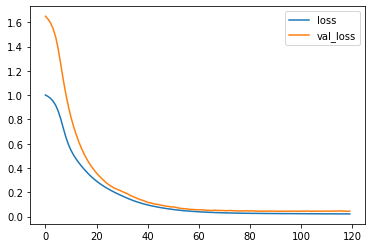

In [20]:
pd.DataFrame(oPredictiveModel.history.history).plot()

## Test Model

In [21]:
oPredictiveModel.load_weights(sModelName)

aPrediction = oPredictiveModel.predict(aInputTest)
aPrediction = aPrediction.reshape((-1, iForwardTimeWindow * iNrOutputFeatures))
dfPrediction = pd.DataFrame(aPrediction, index = ixTest, columns = ixOutputColums)

aActual = aOutputTest.reshape((-1, iForwardTimeWindow * iNrOutputFeatures))
dfActual =  pd.DataFrame(aActual, index = ixTest, columns = ixOutputColums)

for sOutputFeature in aOutputFeatures:
    sScalerFilePath = os.path.join(sModelName , "__scalers__")
    sScalerFilePath = os.path.join(sScalerFilePath , sColumn + ".sav")
    oScaler = pickle.load(open(sScalerFilePath, 'rb'))
    
    tplMaskFeature = (slice(None), slice(sOutputFeature))
    
    dfPrediction.loc[:,tplMaskFeature] = oScaler.inverse_transform(dfPrediction.loc[:, tplMaskFeature])
    dfActual.loc[:, tplMaskFeature] =  oScaler.inverse_transform(dfActual.loc[:, tplMaskFeature])

# RESULTS

In [22]:
iComparisionTimeStep = 0
iFrom = 1 * iForwardTimeWindow
iTo = iFrom + iForwardTimeWindow

In [23]:
y_pred = dfPrediction.iloc[:, iComparisionTimeStep]
y_true = dfActual.iloc[:, iComparisionTimeStep]
aMetrics = [
        ('mean absolute error', mean_absolute_error(y_true, y_pred)),
        ('mean squared error', mean_squared_error(y_true, y_pred)),
        ('max error', max_error(y_true, y_pred)),
        ('r2 score', r2_score(y_true, y_pred))
    ]

print('Metrics for regression:')
for metric_name, metric_value in aMetrics:
    print(f'{metric_name:>25s}: {metric_value: >20.3f}')

Metrics for regression:
      mean absolute error:                2.569
       mean squared error:               12.374
                max error:               11.747
                 r2 score:                0.919


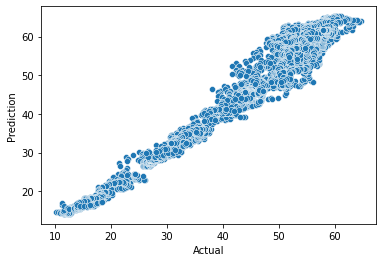

In [24]:
dfTestComparision = pd.DataFrame(dfPrediction.iloc[:,iComparisionTimeStep])
dfTestComparision = dfTestComparision.join(dfActual.iloc[:,iComparisionTimeStep], how = "inner", lsuffix="prediction")
dfTestComparision.columns = ["Prediction", "Actual"]

sns.scatterplot(data = dfTestComparision, x = "Actual", y ="Prediction")

-1.2395365485301189


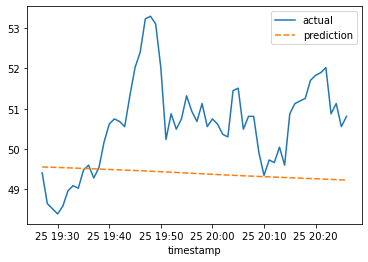

In [25]:
sFeatureName = "close"
dfStepComparision = dfActual.iloc[iFrom:iTo].loc[:, (slice(None), slice(sOutputFeature))].loc[:, 0]
dfStepComparision.columns = ["actual"]

dfStepComparision["prediction"] = dfPrediction.iloc[iFrom].loc[:, sFeatureName].values

print(r2_score(dfStepComparision["actual"], dfStepComparision["prediction"]))
sns.lineplot(data = dfStepComparision)

# REFERENCES

https://www.tensorflow.org/guide/keras/train_and_evaluate#passing_data_to_multi-input_multi-output_models

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/

https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/

https://towardsdatascience.com/customize-loss-function-to-make-lstm-model-more-applicable-in-stock-price-prediction-b1c50e50b16c

https://keras.io/getting_started/faq/

https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

https://www.tensorflow.org/tutorials/structured_data/time_series

https://towardsdatascience.com/encoder-decoder-model-for-multistep-time-series-forecasting-using-pytorch-5d54c6af6e60